In [1]:
""" 
Title: Eating disorders Montecatini 
Author: Corrado Caudek
Description: Check effect of comorbidity (0 = absent, 1 = present) on HDDMRL parameters.
Version History:
- v1.0 (January 31, 2023): Initial version
- v1.1 (July 9, 2023): Updated version
Contact: corrado.caudek@unifi.it
"""


# Virtual environment: py37_env

import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-07-09 10:42:14


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [2]:
%matplotlib inline 

import os, time, csv, sys
import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

import pymc
import pymc as pm
import hddm
import kabuki
import arviz as az

import pymc.progressbar as pbar
import pathlib

from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin

from patsy import dmatrix  # for generation of (regression) design matrices
import pickle

from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

print(f"The hddm version is {hddm.__version__}")

/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The hddm version is 0.9.8


In [12]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

In [4]:
# Set display options to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Reset display options to their default values
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [5]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, 'wb') as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, 'rb'))
    return model


hddm.load1 = load1


In [6]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()
                   ) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(
                data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.ix[obs['node'].value.index])
                     for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(
            datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])


In [7]:
pwd

'/Users/corrado/_repositories/eating_disorders_23/src/python/PRL/02_commorbidity'

Load data

In [8]:
data = hddm.load_csv(
    '/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/comorbidity/an_comorbidity.csv'
)

In [9]:
print('There are %d participants' % data['subj_idx'].nunique())

There are 36 participants


In [10]:
data["subj_code"].unique()

array(['ca_po_2002_05_25_700_f', 'em_or_2003_01_02_101_f',
       'au_ru_1998_09_21_806_f', 'ch_na_2007_06_23_908_f',
       'ch_ma_2001_10_27_332_f', 'bi_di_2006_04_20_725_f',
       'as_ga_2005_06_15_329_f', 'da_de_1998_08_15_141_m',
       'cl_pu_2007_05_24_423_f', 'gr_bo_1996_07_31_547_f',
       'fr_la_2004_05_17_363_f', 'ar_ce_2005_04_20_937_f',
       'fe_sa_2002_05_09_008_f', 'am_gu_1999_02_11_937_f',
       'be_ma_1999_06_15_475_f', 'fe_ma_1998_06_29_257_f',
       'ch_ri_1993_05_05_564_f', 'gi_za_1992_09_07_575_f',
       'ir_ve_2004_02_09_500_f', 'an_de_1998_11_10_289_f',
       'ma_va_1998_07_04_538_f', 'ir_pi_2002_01_22_765_f',
       'em_gr_2002_08_25_628_f', 'gi_ma_1999_09_26_585_f',
       'so_be_2008_12_15_399_f', 'ir_to_2007_08_01_838_f',
       'ch_ca_2000_09_26_406_f', 'em_al_1989_07_27_200_f',
       'ch_pi_2004_02_25_126_f', 'es_bo_2004_07_23_474_f',
       'em_bi_2007_12_28_766_f', 'cr_gi_1994_10_14_378_f',
       'ch_br_1993_10_04_623_f', 'he_ha_2006_04_21_874_f

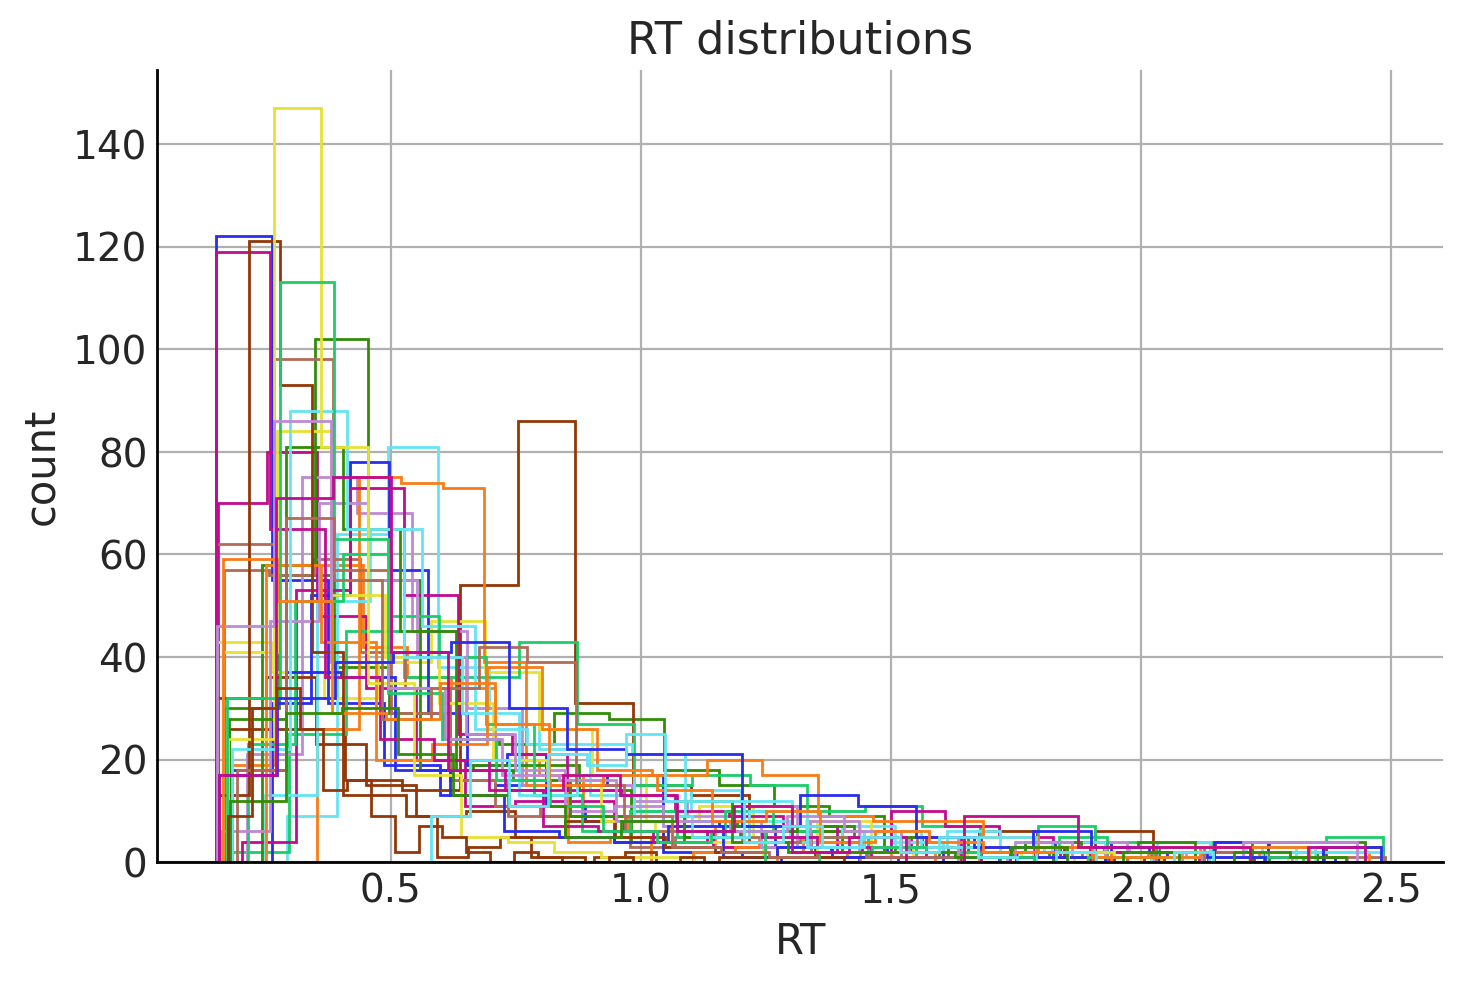

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count',
                     title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_hist_rt_patients.pdf')


In [14]:
data.groupby(["comorbidity", "stim"]).agg({"feedback": "mean"})

feedback
comorbidity stim             
0           food     0.544792
            neutral  0.568056
1           food     0.519922
            neutral  0.532083

In [16]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init,comorbidity,medication
0,1,0,food,0.979,1,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
1,1,1,food,1.939,2,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
2,1,0,food,0.768,3,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
3,1,0,food,1.271,4,0,1,AN,ca_po_2002_05_25_700_f,0.5,0,0
4,1,1,food,1.929,5,0,1,AN,ca_po_2002_05_25_700_f,0.5,0,0


In [17]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod = hddm.HDDMrl(
    data,
    # bias=True,
    depends_on={
        "a": ["comorbidity", "stim"],
        "v": ["comorbidity", "stim"],
        "t": ["comorbidity", "stim"],
        "alpha": ["comorbidity", "stim"],
        "pos_alpha": ["comorbidity", "stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
    include=["v", "a", "t"],
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [18]:
mod.find_starting_values()

/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [19]:
mod.sample(5000, burn=2000, dbname="models/ddm.db", db="pickle")

 [-----------------100%-----------------] 5001 of 5000 complete in 1803.1 sec

FileNotFoundError: [Errno 2] No such file or directory: 'models/ddm.db'

In [21]:
# get model traces 
grptrcs=mod.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod.get_traces() # traces of all stochastic nodes

In [22]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')

In [23]:
print("mod DIC: %f" % mod.dic)

mod DIC: 12059.874747


Done saving traces (202206180603)

In [60]:
# get the individual node
subj_data = mod.get_subj_nodes()
subj_data.head()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init,comorbidity,medication,mean,std,2.5q,25q,50q,75q,97.5q,mc err,map
a_subj(0.food).1,a_subj,True,False,True,a_subj(0.food).1,"(0, food)","[comorbidity, stim, subj_idx]",False,1,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.272967
a_subj(0.food).2,a_subj,True,False,True,a_subj(0.food).2,"(0, food)","[comorbidity, stim, subj_idx]",False,2,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.367406
a_subj(0.food).3,a_subj,True,False,True,a_subj(0.food).3,"(0, food)","[comorbidity, stim, subj_idx]",False,3,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.494849
a_subj(0.food).5,a_subj,True,False,True,a_subj(0.food).5,"(0, food)","[comorbidity, stim, subj_idx]",False,5,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580219
a_subj(0.food).6,a_subj,True,False,True,a_subj(0.food).6,"(0, food)","[comorbidity, stim, subj_idx]",False,6,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.503569


In [68]:
alpha_nc_f, alpha_nc_n, alpha_c_f, alpha_c_n = mod.nodes_db.node[
    [
        "alpha(0.food)",
        "alpha(0.neutral)",
        "alpha(1.food)",
        "alpha(1.neutral)",
    ]
]

pos_alpha_nc_f, pos_alpha_nc_n, pos_alpha_c_f, pos_alpha_c_n = mod.nodes_db.node[
    [
        "pos_alpha(0.food)",
        "pos_alpha(0.neutral)",
        "pos_alpha(1.food)",
        "pos_alpha(1.neutral)",
    ]
]

Text(0.5, 1.0, 'Posterior of negative alpha group means\nDisorder-related context')

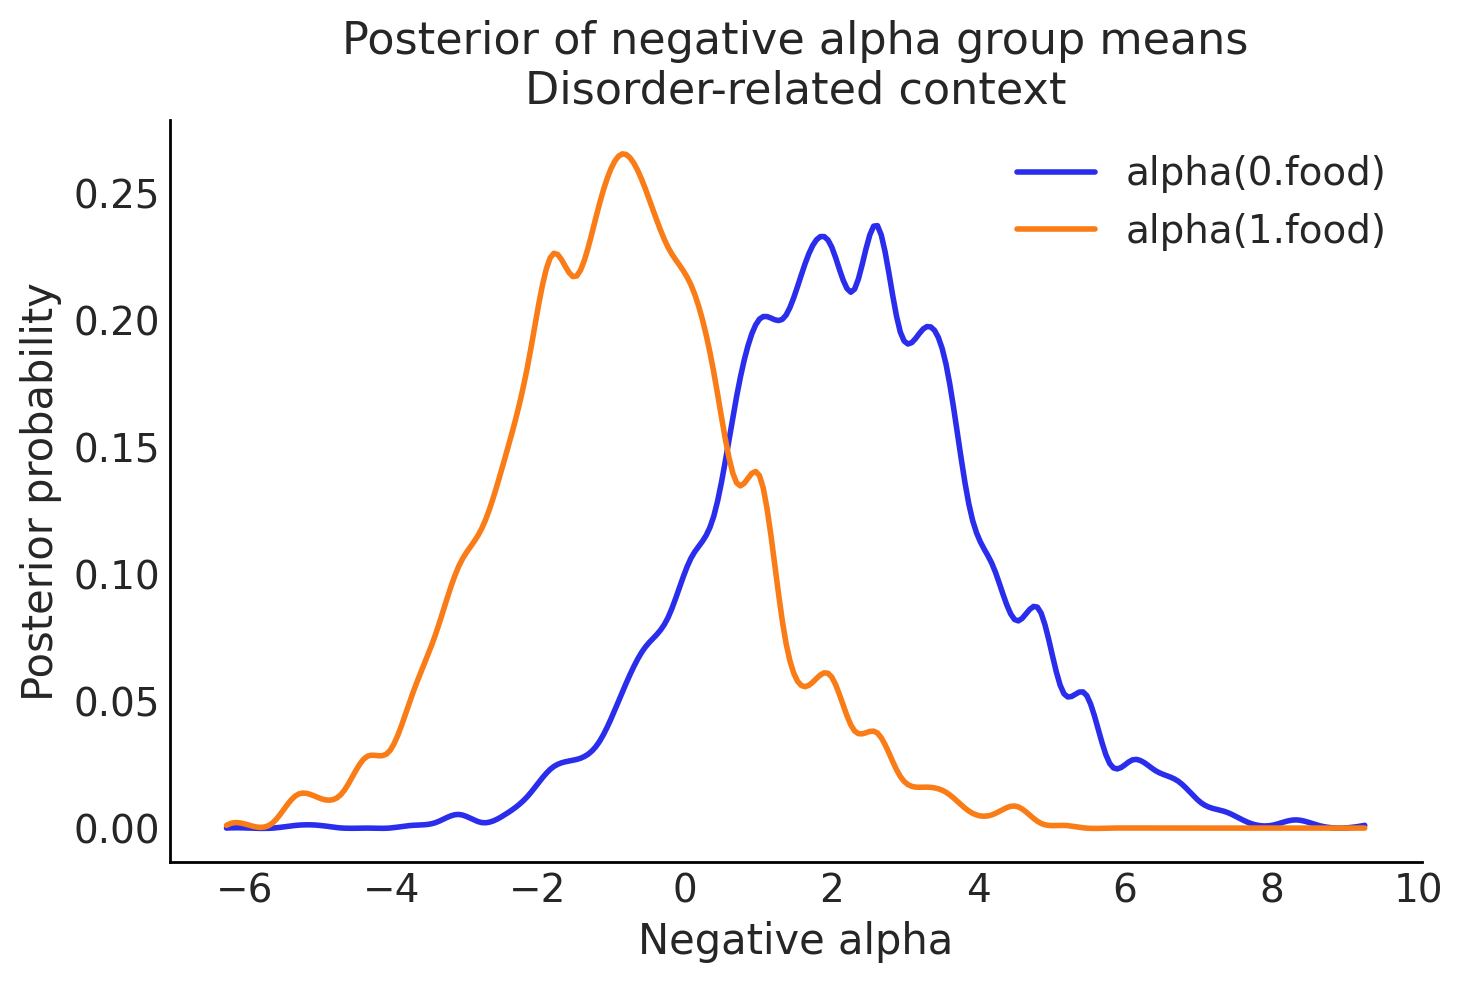

In [67]:
hddm.analyze.plot_posterior_nodes([alpha_nc_f, alpha_c_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means\nDisorder-related context')

Text(0.5, 1.0, 'Posterior of negative alpha group means\nDisorder-unrelated context')

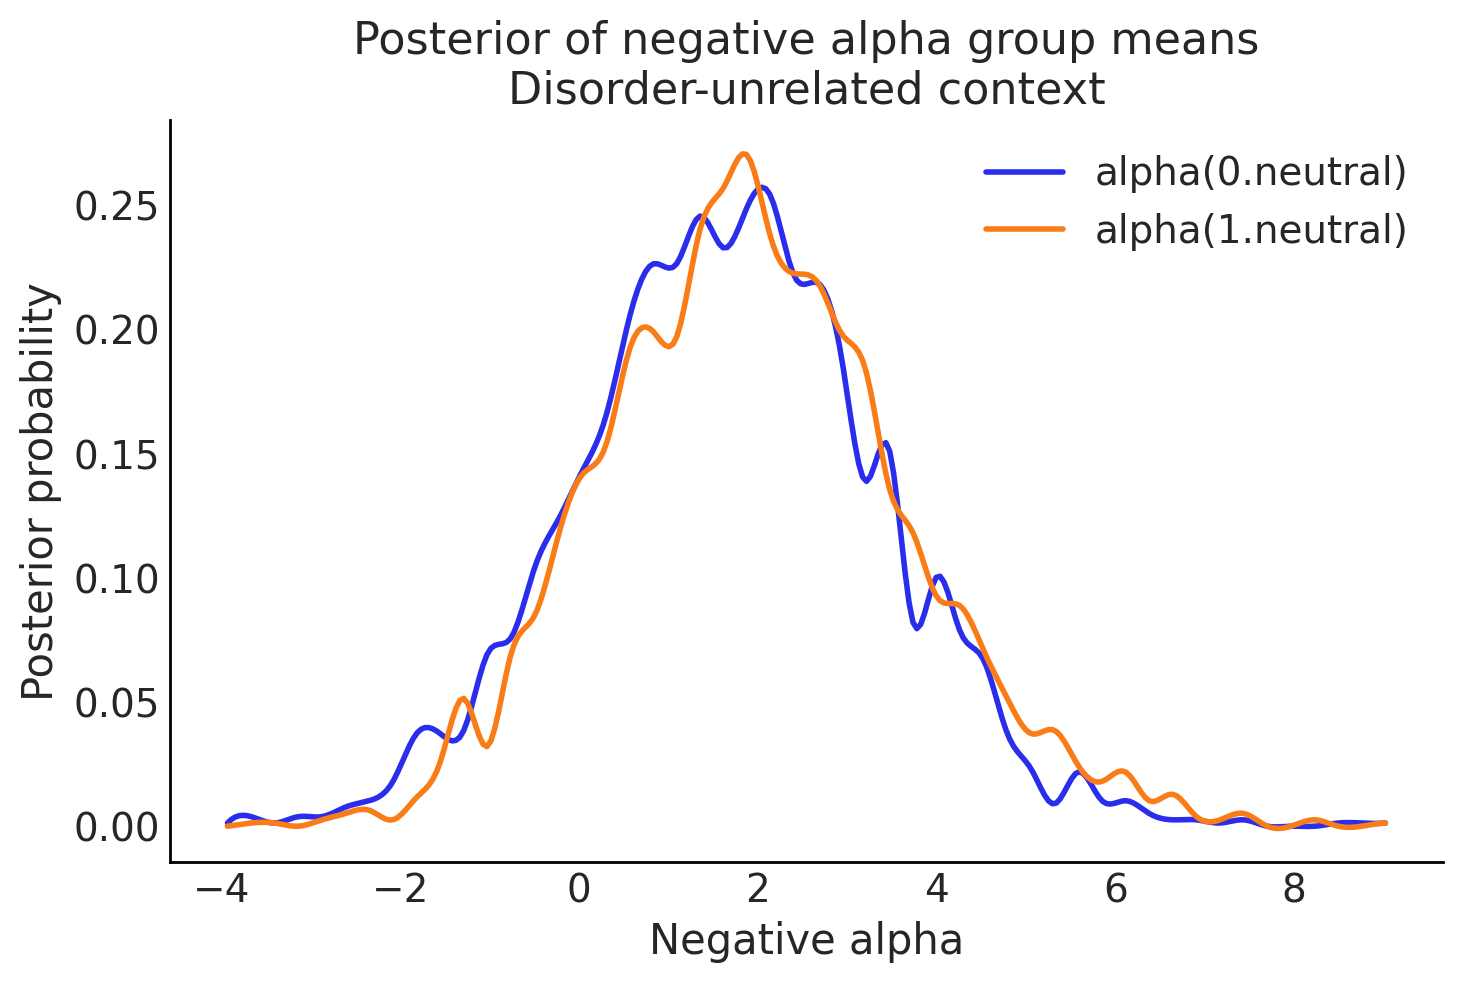

In [66]:
hddm.analyze.plot_posterior_nodes([alpha_nc_n, alpha_c_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means\nDisorder-unrelated context')

Text(0.5, 1.0, 'Posterior of positive alpha group means\nDisorder-related context')

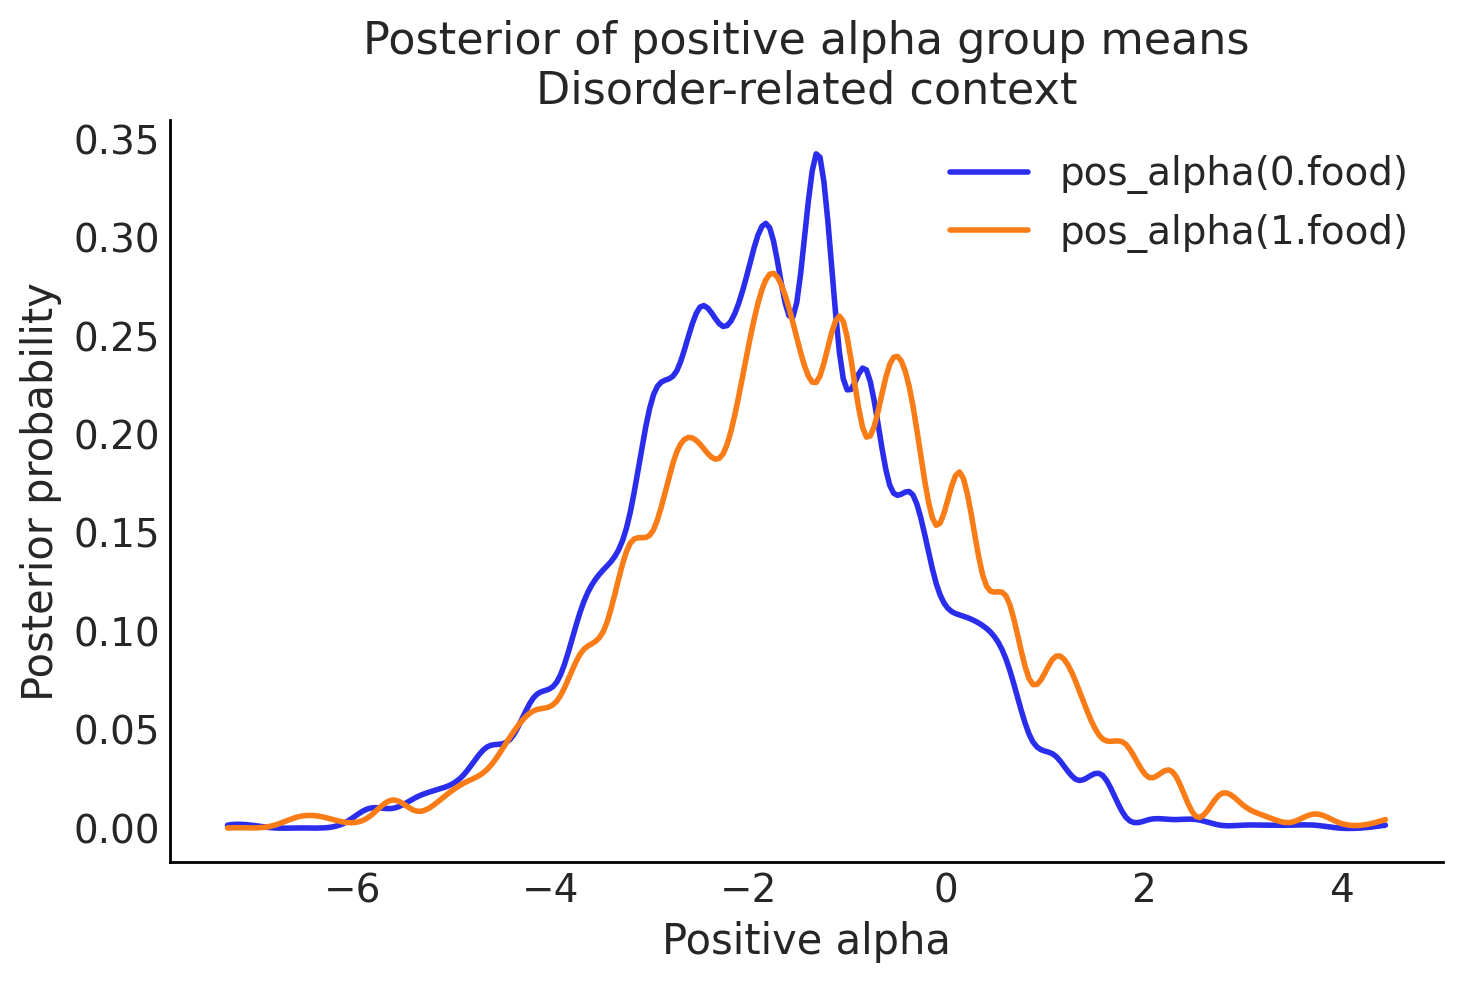

In [69]:
hddm.analyze.plot_posterior_nodes([pos_alpha_nc_f, pos_alpha_c_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means\nDisorder-related context')

Text(0.5, 1.0, 'Posterior of positive alpha group means\nDisorder-unrelated context')

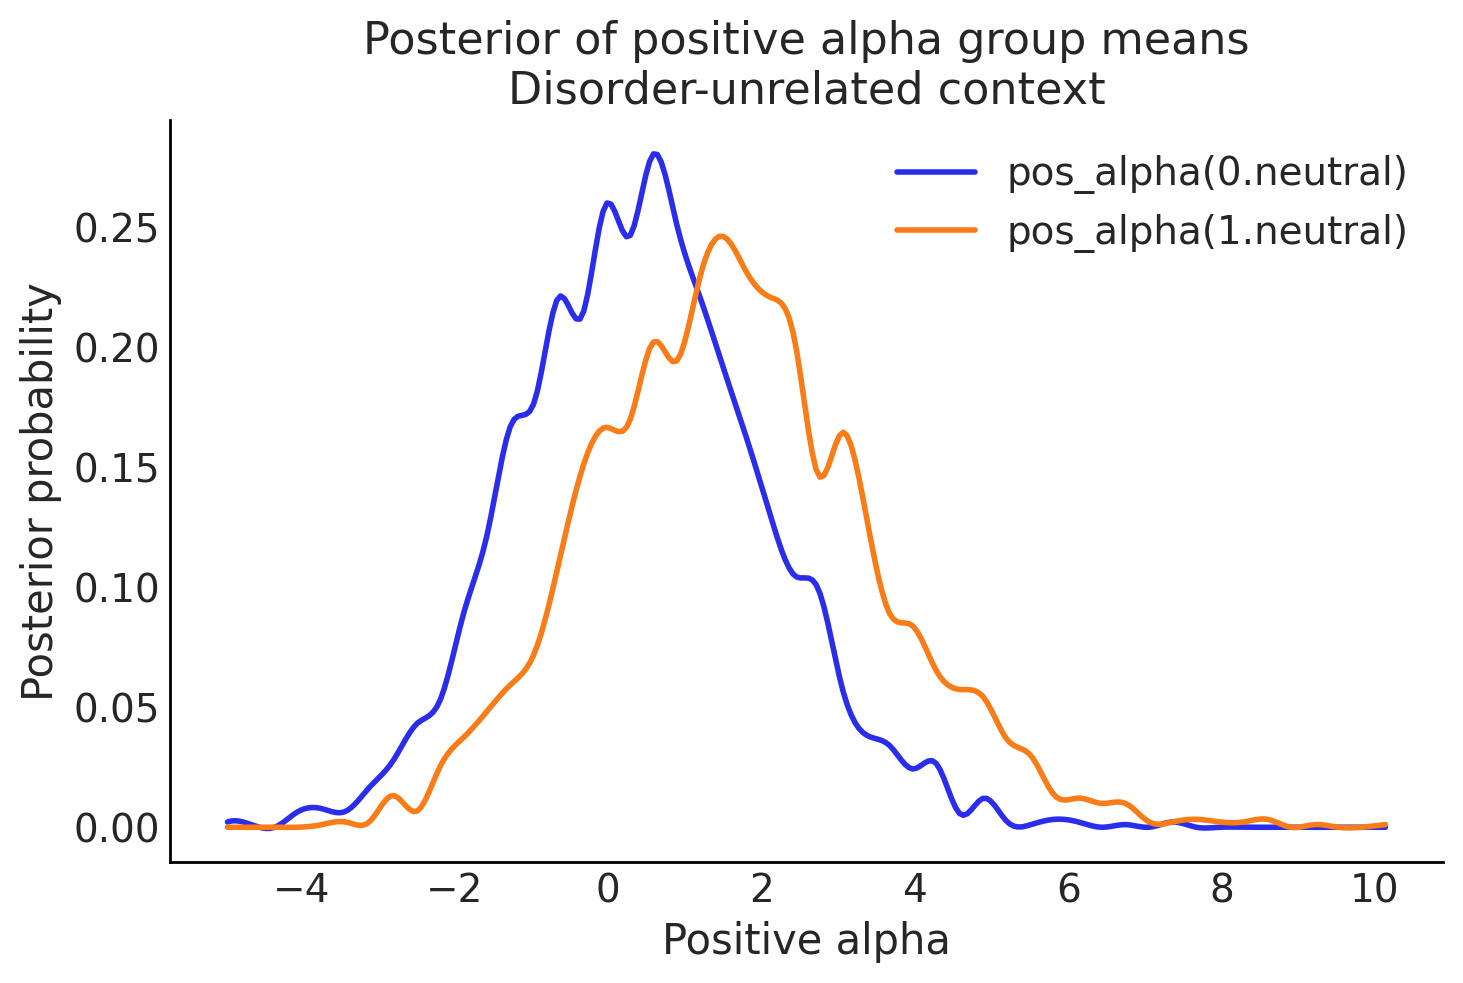

In [70]:
hddm.analyze.plot_posterior_nodes([pos_alpha_nc_n, pos_alpha_c_n])
plt.xlabel("Positive alpha")
plt.ylabel("Posterior probability")
plt.title("Posterior of positive alpha group means\nDisorder-unrelated context")

In [62]:
traces = mod.get_traces()
traces.head()


,a(0.food),a(0.neutral),a(1.food),a(1.neutral),a_std,a_subj(0.food).1,a_subj(0.food).2,a_subj(0.food).3,a_subj(0.food).5,a_subj(0.food).6,a_subj(0.food).9,a_subj(0.food).12,a_subj(0.food).15,a_subj(0.food).17,a_subj(0.food).18,a_subj(0.food).19,a_subj(0.food).20,a_subj(0.food).21,a_subj(0.food).24,a_subj(0.food).26,a_subj(0.food).27,a_subj(0.food).30,a_subj(0.food).31,a_subj(0.neutral).1,a_subj(0.neutral).2,a_subj(0.neutral).3,a_subj(0.neutral).5,a_subj(0.neutral).6,a_subj(0.neutral).9,a_subj(0.neutral).12,a_subj(0.neutral).17,a_subj(0.neutral).18,a_subj(0.neutral).19,a_subj(0.neutral).20,a_subj(0.neutral).24,a_subj(0.neutral).26,a_subj(0.neutral).27,a_subj(0.neutral).30,a_subj(0.neutral).31,a_subj(0.neutral).35,a_subj(0.neutral).36,a_subj(1.food).4,a_subj(1.food).7,a_subj(1.food).8,a_subj(1.food).10,a_subj(1.food).11,a_subj(1.food).13,a_subj(1.food).14,a_subj(1.food).16,a_subj(1.food).22,a_subj(1.food).23,a_subj(1.food).25,a_subj(1.food).28,a_subj(1.food).29,a_subj(1.food).32,a_subj(1.food).33,a_subj(1.food).34,a_subj(1.neutral).4,a_subj(1.neutral).7,a_subj(1.neutral).8,a_subj(1.neutral).10,a_subj(1.neutral).11,a_subj(1.neutral).13,a_subj(1.neutral).14,a_subj(1.neutral).16,a_subj(1.neutral).22,a_subj(1.neutral).23,a_subj(1.neutral).25,a_subj(1.neutral).28,a_subj(1.neutral).29,a_subj(1.neutral).32,a_subj(1.neutral).34,v(0.food),v(0.neutral),v(1.food),v(1.neutral),v_std,v_subj(0.food).1,v_subj(0.food).2,v_subj(0.food).3,v_subj(0.food).5,v_subj(0.food).6,v_subj(0.food).9,v_subj(0.food).12,v_subj(0.food).15,v_subj(0.food).17,v_subj(0.food).18,v_subj(0.food).19,v_subj(0.food).20,v_subj(0.food).21,v_subj(0.food).24,v_subj(0.food).26,v_subj(0.food).27,v_subj(0.food).30,v_subj(0.food).31,v_subj(0.neutral).1,v_subj(0.neutral).2,v_subj(0.neutral).3,v_subj(0.neutral).5,v_subj(0.neutral).6,v_subj(0.neutral).9,v_subj(0.neutral).12,v_subj(0.neutral).17,v_subj(0.neutral).18,v_subj(0.neutral).19,v_subj(0.neutral).20,v_subj(0.neutral).24,v_subj(0.neutral).26,v_subj(0.neutral).27,v_subj(0.neutral).30,v_subj(0.neutral).31,v_subj(0.neutral).35,v_subj(0.neutral).36,v_subj(1.food).4,v_subj(1.food).7,v_subj(1.food).8,v_subj(1.food).10,v_subj(1.food).11,v_subj(1.food).13,v_subj(1.food).14,v_subj(1.food).16,v_subj(1.food).22,v_subj(1.food).23,v_subj(1.food).25,v_subj(1.food).28,v_subj(1.food).29,v_subj(1.food).32,v_subj(1.food).33,v_subj(1.food).34,v_subj(1.neutral).4,v_subj(1.neutral).7,v_subj(1.neutral).8,v_subj(1.neutral).10,v_subj(1.neutral).11,v_subj(1.neutral).13,v_subj(1.neutral).14,v_subj(1.neutral).16,v_subj(1.neutral).22,v_subj(1.neutral).23,v_subj(1.neutral).25,v_subj(1.neutral).28,v_subj(1.neutral).29,v_subj(1.neutral).32,v_subj(1.neutral).34,t(0.food),t(0.neutral),t(1.food),t(1.neutral),t_std,t_subj(0.food).1,t_subj(0.food).2,t_subj(0.food).3,t_subj(0.food).5,t_subj(0.food).6,t_subj(0.food).9,t_subj(0.food).12,t_subj(0.food).15,t_subj(0.food).17,t_subj(0.food).18,t_subj(0.food).19,t_subj(0.food).20,t_subj(0.food).21,t_subj(0.food).24,t_subj(0.food).26,t_subj(0.food).27,t_subj(0.food).30,t_subj(0.food).31,t_subj(0.neutral).1,t_subj(0.neutral).2,t_subj(0.neutral).3,t_subj(0.neutral).5,t_subj(0.neutral).6,t_subj(0.neutral).9,t_subj(0.neutral).12,t_subj(0.neutral).17,t_subj(0.neutral).18,t_subj(0.neutral).19,t_subj(0.neutral).20,t_subj(0.neutral).24,t_subj(0.neutral).26,t_subj(0.neutral).27,t_subj(0.neutral).30,t_subj(0.neutral).31,t_subj(0.neutral).35,t_subj(0.neutral).36,t_subj(1.food).4,t_subj(1.food).7,t_subj(1.food).8,t_subj(1.food).10,t_subj(1.food).11,t_subj(1.food).13,t_subj(1.food).14,t_subj(1.food).16,t_subj(1.food).22,t_subj(1.food).23,t_subj(1.food).25,t_subj(1.food).28,t_subj(1.food).29,t_subj(1.food).32,t_subj(1.food).33,t_subj(1.food).34,t_subj(1.neutral).4,t_subj(1.neutral).7,t_subj(1.neutral).8,t_subj(1.neutral).10,t_subj(1.neutral).11,t_subj(1.neutral).13,t_subj(1.neutral).14,t_subj(1.neutral).16,t_subj(1.neutral).22,t_subj(1.neutral).23,t_subj(1.neutral).25,t_subj(1.neutral).28,t_subj(1.neutral).29,t_subj(1.neutral).32,t_s

## Decision threshold

Parameter `a` as a function of comorbidity (0=absent; 1=present)

In [29]:
traces['score_diff'] = traces['a(0.food)'] - traces['a(1.food)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.170179
0.500   -0.011237
0.975    0.147736
Name: score_diff, dtype: float64

In [30]:
traces['score_diff'] = traces['a(0.neutral)'] - traces['a(1.neutral)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.241827
0.500   -0.079128
0.975    0.083651
Name: score_diff, dtype: float64

## Drift rate

Parameter `v` as a function of comorbidity (0=absent; 1=present)

In [37]:
traces["score_diff"] = traces["v(0.food)"] - traces["v(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -1.253588
0.500    0.842706
0.975    2.882705
Name: score_diff, dtype: float64

In [38]:
traces["score_diff"] = traces["v(0.neutral)"] - traces["v(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.501941
0.500    1.525233
0.975    3.463962
Name: score_diff, dtype: float64

## Non-decision time

Parameter `t` as a function of comorbidity (0=absent; 1=present)

In [39]:
traces["score_diff"] = traces["t(0.food)"] - traces["t(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
print(quantiles)

0.025   -0.052797
0.500   -0.001463
0.975    0.047529
Name: score_diff, dtype: float64


In [40]:
traces["score_diff"] = traces["t(0.neutral)"] - traces["t(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
print(quantiles)

0.025   -0.056979
0.500   -0.004044
0.975    0.050293
Name: score_diff, dtype: float64


## Negative alpha 

Parameter `alpha` as function of comorbidity (0=absent; 1=present)

In [58]:
traces["score_diff"] = traces["alpha(0.food)"] - traces["alpha(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -1.853824
0.500    2.925307
0.975    7.859133
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-related context')

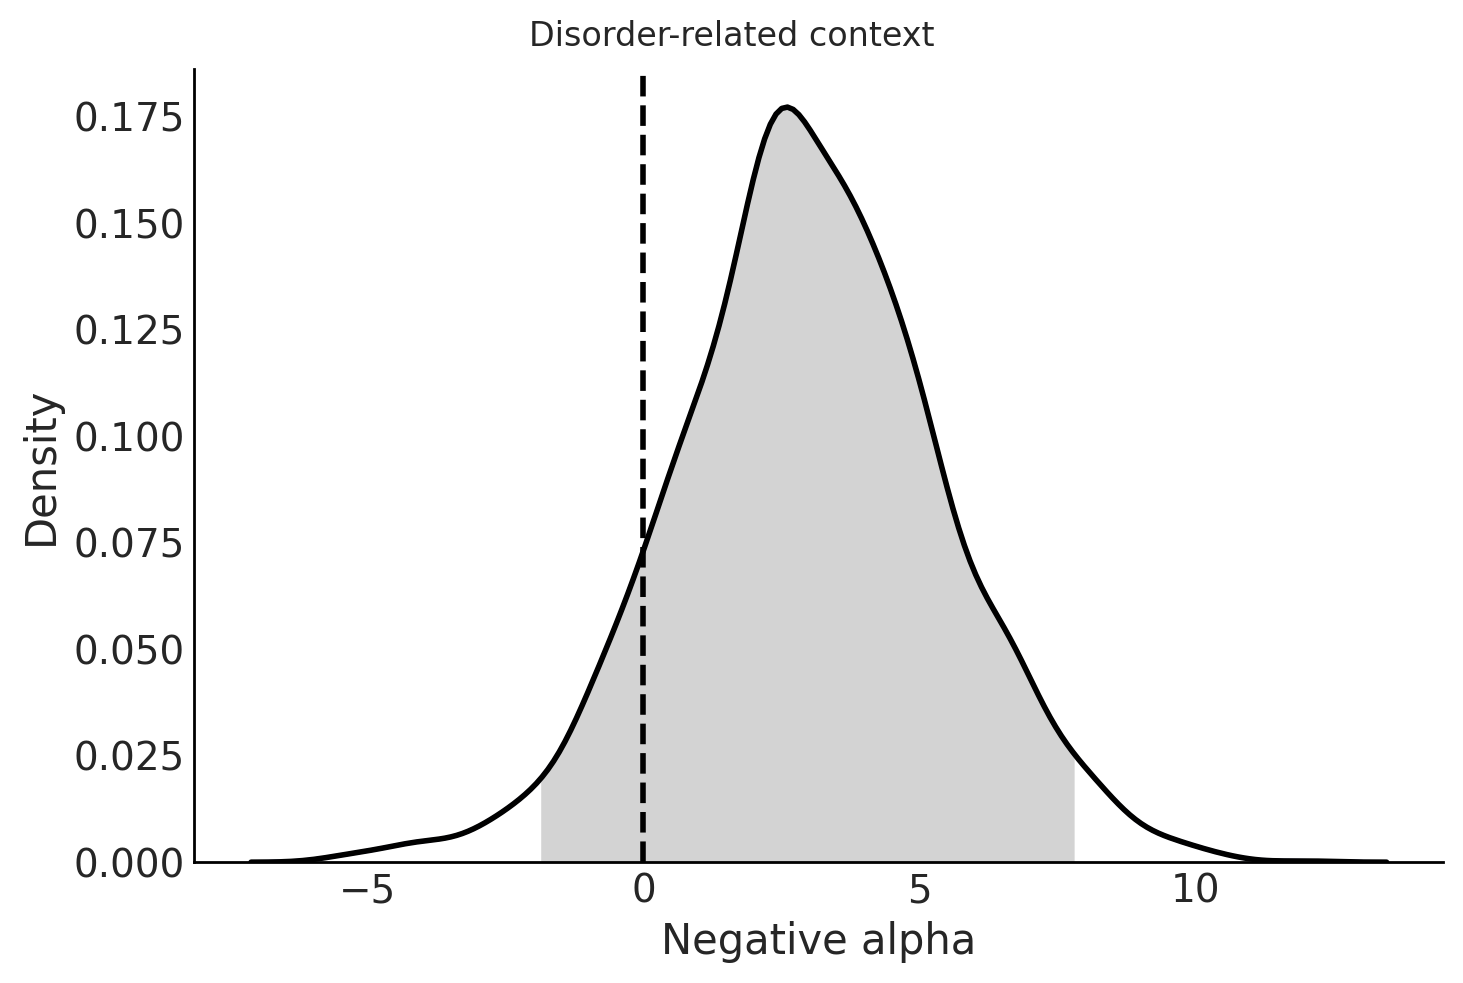

In [59]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Negative alpha")
sns_plot.figure.suptitle("Disorder-related context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

In [56]:
traces["score_diff"] = traces["alpha(0.neutral)"] - traces["alpha(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -4.972450
0.500   -0.287118
0.975    4.141427
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-unrelated context')

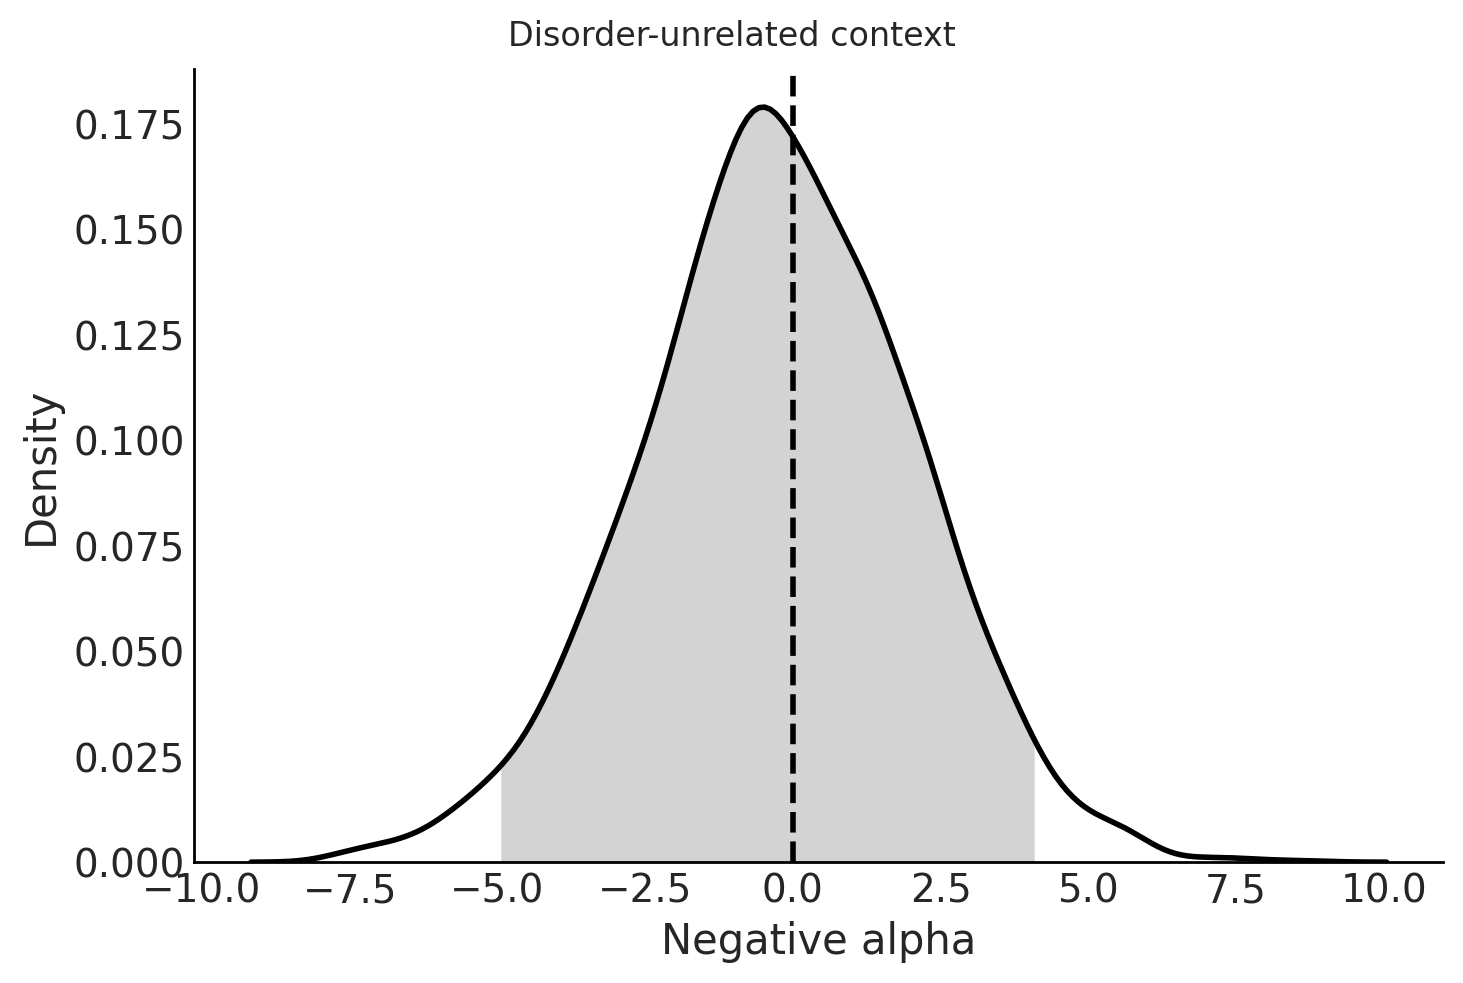

In [57]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Negative alpha")
sns_plot.figure.suptitle("Disorder-unrelated context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

## Positive alpha 

Parameter `pos_alpha` as function of comorbidity (0=absent; 1=present)

In [54]:
traces['score_diff'] = traces['pos_alpha(0.food)'] - traces['pos_alpha(1.food)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -4.660729
0.500   -0.401159
0.975    3.760275
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-related context')

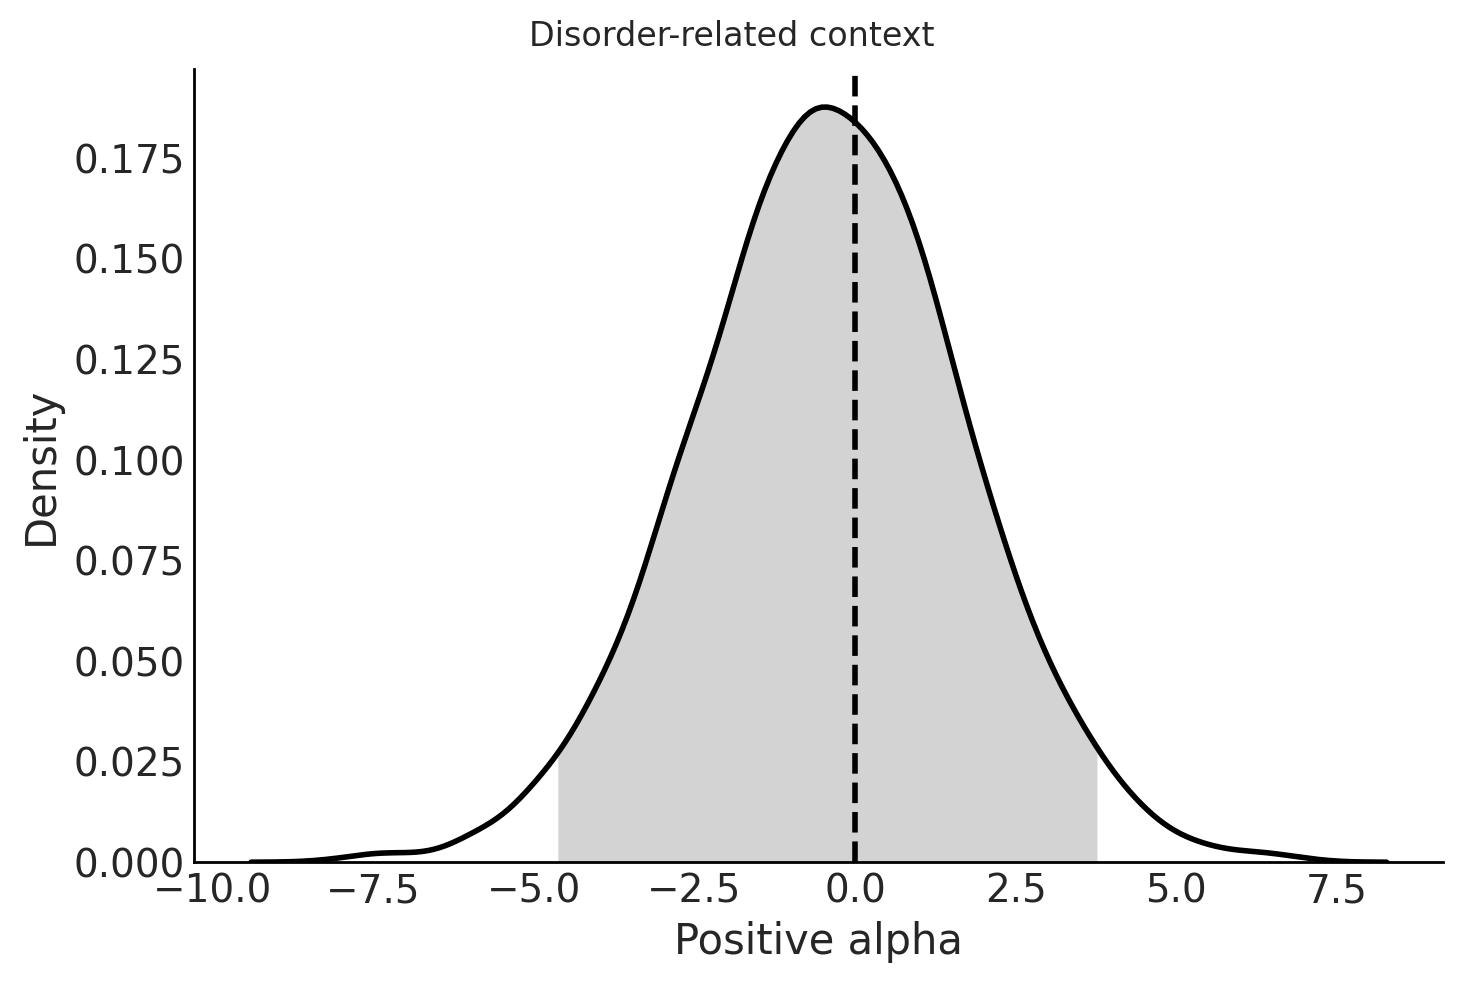

In [55]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Positive alpha")
sns_plot.figure.suptitle("Disorder-related context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

In [51]:
traces["score_diff"] = traces["pos_alpha(0.neutral)"] - traces["pos_alpha(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -5.991276
0.500   -1.080627
0.975    3.522128
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-unrelated context')

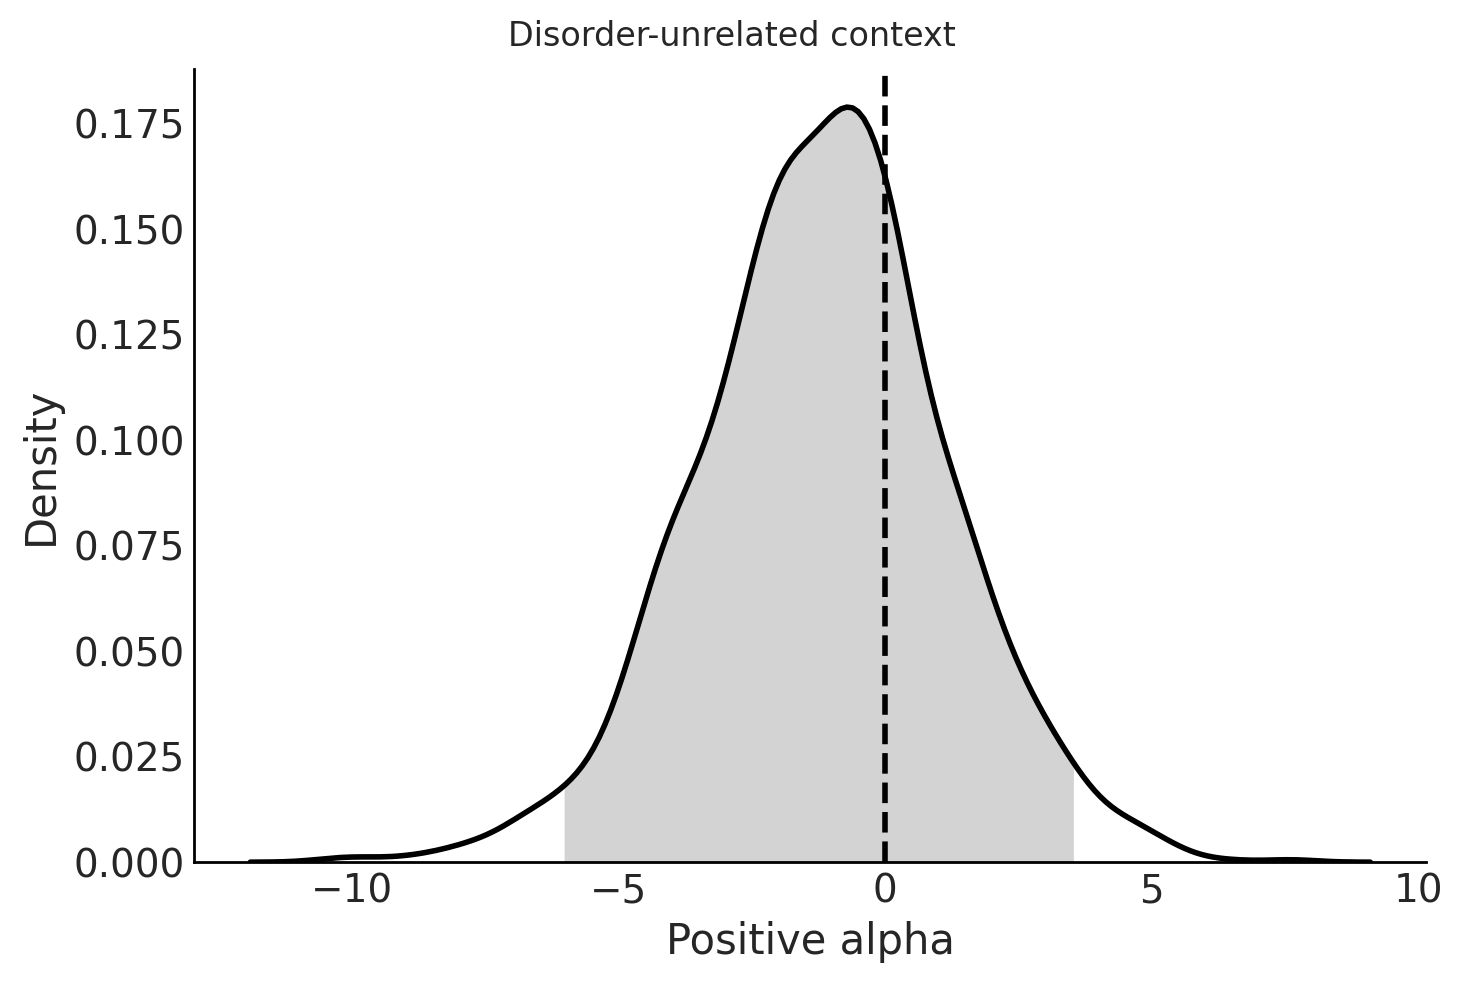

In [52]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Positive alpha")
sns_plot.figure.suptitle("Disorder-unrelated context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

The following code creates a figure of the posterior density plot of the difference between the parameters estimated in two conditions.


In [71]:
mod.plot_posterior_predictive()


/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/kabuki/analyze.py:625: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [50]:
print("P(neg-alpha AN food > neg-alpha HC food) = ",
      (alpha_an_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN neutral > neg-alpha HC neutral) = ",
      (alpha_an_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN food > pos-alpha HC food) = ",
      (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN neutral > pos-alpha HC neutral) = ",
      (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN food > neg-alpha HC food) =  0.0073
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.112
P(pos-alpha AN food > pos-alpha HC food) =  0.0003
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.4292


In [51]:
print("P(neg-alpha AN-R food > neg-alpha HC food) = ",
      (alpha_anr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN-R neutral > neg-alpha HC neutral) = ",
      (alpha_anr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN-R food > pos-alpha HC food) = ",
      (pos_alpha_anr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN-R neutral > pos-alpha HC neutral) = ",
      (pos_alpha_anr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN-R food > neg-alpha HC food) =  0.362
P(neg-alpha AN-R neutral > neg-alpha HC neutral) =  0.3236
P(pos-alpha AN-R food > pos-alpha HC food) =  0.5352
P(pos-alpha AN-R neutral > pos-alpha HC neutral) =  0.259


In [52]:
print("P(neg-alpha BN food > neg-alpha HC food) = ",
      (alpha_bn_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral > neg-alpha HC neutral) = ",
      (alpha_bn_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food > pos-alpha HC food) = ",
      (pos_alpha_bn_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral > pos-alpha HC neutral) = ",
      (pos_alpha_bn_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food > neg-alpha HC food) =  0.0675
P(neg-alpha BN neutral > neg-alpha HC neutral) =  0.1582
P(pos-alpha BN food > pos-alpha HC food) =  0.3888
P(pos-alpha BN neutral > pos-alpha HC neutral) =  0.3821


In [53]:
print("P(neg-alpha BN-R food > neg-alpha HC food) = ",
      (alpha_bnr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN-R neutral > neg-alpha HC neutral) = ",
      (alpha_bnr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN-R food > pos-alpha HC food) = ",
      (pos_alpha_bnr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN-R neutral > pos-alpha HC neutral) = ",
      (pos_alpha_bnr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN-R food > neg-alpha HC food) =  0.3942
P(neg-alpha BN-R neutral > neg-alpha HC neutral) =  0.3401
P(pos-alpha BN-R food > pos-alpha HC food) =  0.6585
P(pos-alpha BN-R neutral > pos-alpha HC neutral) =  0.3457


In [54]:
print("P(neg-alpha RI food > neg-alpha HC food) = ",
      (alpha_ri_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha RI neutral > neg-alpha HC neutral) = ",
      (alpha_ri_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha RI food > pos-alpha HC food) = ",
      (pos_alpha_ri_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha RI neutral > pos-alpha HC neutral) = ",
      (pos_alpha_ri_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha RI food > neg-alpha HC food) =  0.252
P(neg-alpha RI neutral > neg-alpha HC neutral) =  0.0786
P(pos-alpha RI food > pos-alpha HC food) =  0.4909
P(pos-alpha RI neutral > pos-alpha HC neutral) =  0.5893


# Drift rate


In [55]:
v_an_f,  v_an_n, v_anr_f, v_anr_n, v_bn_f,  v_bn_n, v_bnr_f, v_bnr_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)',
    'v(AN_R.food)', 'v(AN_R.neutral)',
    'v(BN.food)',   'v(BN.neutral)',
    'v(BN_R.food)', 'v(BN_R.neutral)',
    'v(HC.food)',   'v(HC.neutral)',
    'v(RI.food)',   'v(RI.neutral)',
]]


In [56]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ",
      (v_an_n.trace() > v_hc_n.trace()).mean())
print("P(v AN-R food > v HC food) = ",
      (v_anr_f.trace() > v_hc_f.trace()).mean())
print("P(v AN-R neutral > v HC neutral) = ",
      (v_anr_n.trace() > v_hc_n.trace()).mean())


P(v AN food > v HC food) =  0.524
P(v AN neutral > v HC neutral) =  0.0509
P(v AN-R food > v HC food) =  0.3167
P(v AN-R neutral > v HC neutral) =  0.668


In [57]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ",
      (v_bn_n.trace() > v_hc_n.trace()).mean())
print("P(v BN-R food > v HC food) = ",
      (v_bnr_f.trace() > v_hc_f.trace()).mean())
print("P(v BN-R neutral > v HC neutral) = ",
      (v_bnr_n.trace() > v_hc_n.trace()).mean())


P(v BN food > v HC food) =  0.299
P(v BN neutral > v HC neutral) =  0.9032
P(v BN-R food > v HC food) =  0.3397
P(v BN-R neutral > v HC neutral) =  0.5108


In [58]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ",
      (v_ri_n.trace() > v_hc_n.trace()).mean())


P(v RI food > v HC food) =  0.2927
P(v RI neutral > v HC neutral) =  0.8478


# Decision threshold


In [59]:
a_an_f,  a_an_n, a_anr_f, a_anr_n, a_bn_f,  a_bn_n, a_bnr_f, a_bnr_n, a_hc_f,  a_hc_n, a_ri_f,  a_ri_n = mod1.nodes_db.node[[
    'a(AN.food)',   'a(AN.neutral)',
    'a(AN_R.food)', 'a(AN_R.neutral)',
    'a(BN.food)',   'a(BN.neutral)',
    'a(BN_R.food)', 'a(BN_R.neutral)',
    'a(HC.food)',   'a(HC.neutral)',
    'a(RI.food)',   'a(RI.neutral)',
]]


In [60]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ",
      (a_an_n.trace() < a_hc_n.trace()).mean())
print("P(a AN-R food < a HC food) = ",
      (a_anr_f.trace() < a_hc_f.trace()).mean())
print("P(a AN-R neutral < a HC neutral) = ",
      (a_anr_n.trace() < a_hc_n.trace()).mean())


P(a AN food < a HC food) =  0.0397
P(a AN neutral < a HC neutral) =  0.4874
P(a AN-R food < a HC food) =  0.4986
P(a AN-R neutral < a HC neutral) =  0.2346


In [61]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ",
      (a_bn_n.trace() < a_hc_n.trace()).mean())
print("P(a BN-R food < a HC food) = ",
      (a_bnr_f.trace() < a_hc_f.trace()).mean())
print("P(a BN-R neutral < a HC neutral) = ",
      (a_bnr_n.trace() < a_hc_n.trace()).mean())


P(a BN food < a HC food) =  0.0785
P(a BN neutral < a HC neutral) =  0.6463
P(a BN-R food < a HC food) =  0.3929
P(a BN-R neutral < a HC neutral) =  0.3715


In [62]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ",
      (a_ri_n.trace() < a_hc_n.trace()).mean())


P(a RI food < a HC food) =  0.6223
P(a RI neutral < a HC neutral) =  0.6777


# Non decision time


In [63]:
t_an_f,  t_an_n, t_anr_f, t_anr_n, t_bn_f,  t_bn_n, t_bnr_f, t_bnr_n, t_hc_f,  t_hc_n, t_ri_f,  t_ri_n = mod1.nodes_db.node[[
    't(AN.food)',   't(AN.neutral)',
    't(AN_R.food)', 't(AN_R.neutral)',
    't(BN.food)',   't(BN.neutral)',
    't(BN_R.food)', 't(BN_R.neutral)',
    't(HC.food)',   't(HC.neutral)',
    't(RI.food)',   't(RI.neutral)',
]]


In [64]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ",
      (t_an_n.trace() < t_hc_n.trace()).mean())
print("P(t AN-R food < t HC food) = ",
      (t_anr_f.trace() < t_hc_f.trace()).mean())
print("P(t AN-R neutral < t HC neutral) = ",
      (t_anr_n.trace() < t_hc_n.trace()).mean())


P(t AN food < t HC food) =  0.4772
P(t AN neutral < t HC neutral) =  0.3058
P(t AN-R food < t HC food) =  0.1028
P(t AN-R neutral < t HC neutral) =  0.4938


In [65]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ",
      (t_bn_n.trace() < t_hc_n.trace()).mean())
print("P(t BN-R food < t HC food) = ",
      (t_bnr_f.trace() < t_hc_f.trace()).mean())
print("P(t BN-R neutral < t HC neutral) = ",
      (t_bnr_n.trace() < t_hc_n.trace()).mean())


P(t BN food < t HC food) =  0.6714
P(t BN neutral < t HC neutral) =  0.4629
P(t BN-R food < t HC food) =  0.2623
P(t BN-R neutral < t HC neutral) =  0.3028


In [66]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ",
      (t_ri_n.trace() < t_hc_n.trace()).mean())


P(t RI food < t HC food) =  0.398
P(t RI neutral < t HC neutral) =  0.5025


# Print fitted parameters and other model statistics


In [72]:
mod.print_stats()

                                  mean       std       2.5q        25q       50q       75q      97.5q    mc err
a(0.food)                      1.44231  0.057796   1.327137   1.404436  1.442854  1.480218   1.555021  0.001351
a(0.neutral)                  1.243867  0.056868   1.135929    1.20747   1.24315  1.280369   1.364507  0.001275
a(1.food)                     1.453779  0.059263   1.337503   1.414988  1.455231  1.493695   1.570162  0.001312
a(1.neutral)                  1.323091  0.063219   1.196546   1.282846   1.32368  1.364446   1.445002   0.00133
a_std                          0.23658  0.026547   0.190725   0.218159  0.234667  0.252301   0.296078  0.001008
a_subj(0.food).1              1.272233  0.059011   1.159571   1.232321  1.272681  1.312254   1.389762  0.001824
a_subj(0.food).2              1.353002  0.056162   1.248976   1.314719   1.35111  1.387524   1.473653  0.001558
a_subj(0.food).3              1.542862   0.05686   1.434253   1.503668  1.541583  1.580662   1.659445  0

In [78]:
filtered_df = data[data["subj_idx"] != 25]

## Checking results


### Estimate convergence


In [79]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        filtered_df,
        # bias=True,
        depends_on={
            "a": ["diag_cat", "stim"],
            "v": ["diag_cat", "stim"],
            "t": ["diag_cat", "stim"],
            "alpha": ["diag_cat", "stim"],
            "pos_alpha": ["diag_cat", "stim"],
        },
        dual=True, 
        p_outlier=0.05,
        informative=True,  
        include=["v", "a", "t"],
    )
    m.sample(3000, burn=1000, dbname="traces.db", db="pickle")
    models.append(m)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3001 of 3000 complete in 978.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3000 of 3000 complete in 1000.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3001 of 3000 complete in 922.5 sec

In [80]:
gel_rub = gelman_rubin(models)
print(gel_rub)

{'a(AN.food)': 1.0000134229494861, 'a(AN.neutral)': 1.0001675963156575, 'a_std': 0.9999935739166926, 'a_subj(AN.food).1': 1.0035306858363209, 'a_subj(AN.food).2': 1.0003914162366547, 'a_subj(AN.food).3': 0.9998400722762859, 'a_subj(AN.food).4': 1.0019996947495984, 'a_subj(AN.food).5': 0.9997806757344087, 'a_subj(AN.food).6': 1.001384066523217, 'a_subj(AN.food).7': 1.0002352616530727, 'a_subj(AN.food).8': 1.0022081416627056, 'a_subj(AN.food).9': 1.0000957074344303, 'a_subj(AN.food).10': 1.0010699230999847, 'a_subj(AN.food).11': 1.0000305858790424, 'a_subj(AN.food).12': 1.0034285010380355, 'a_subj(AN.food).13': 1.0002078343853806, 'a_subj(AN.food).14': 0.9998489011222034, 'a_subj(AN.food).15': 1.0011106132869743, 'a_subj(AN.food).16': 0.9999589484816098, 'a_subj(AN.food).17': 1.0010993243071689, 'a_subj(AN.food).18': 0.99998716535394, 'a_subj(AN.food).19': 0.9998117215726273, 'a_subj(AN.food).20': 1.0008981917660535, 'a_subj(AN.food).21': 1.0004698967276417, 'a_subj(AN.food).22': 1.00018

In [81]:
np.max(list(gelman_rubin(models).values()))


1.0325517988590862

In [82]:
np.mean(list(gelman_rubin(models).values()))


1.0015006198975083

In [25]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)


Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what’s usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. Daw, 2011).


In [26]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n, pos_alpha_an_f, pos_alpha_an_n, pos_alpha_hc_f, pos_alpha_hc_n, t_an_f, t_an_n, t_hc_f, t_hc_n, a_an_f, a_an_n, a_hc_f, a_hc_n, v_an_f, v_an_n, v_hc_f, v_hc_n = m.nodes_db.node[[
    'alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)', 'alpha(HC.neutral)',
    'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)', 'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)',
    't(AN.food)', 't(AN.neutral)', 't(HC.food)', 't(HC.neutral)',
    'a(AN.food)', 'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)',
    'v(AN.food)', 'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'
]]


In [27]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'alpha(HC.food)': alpha_hc_f.trace(),
    'alpha(HC.neutral)': alpha_hc_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    'pos_alpha(HC.food)': pos_alpha_hc_f.trace(),
    'pos_alpha(HC.neutral)': pos_alpha_hc_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    't(HC.food)': t_hc_f.trace(),
    't(HC.neutral)': t_hc_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'a(HC.food)': a_hc_f.trace(),
    'a(HC.neutral)': a_hc_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace(),
    'v(HC.food)': v_hc_f.trace(),
    'v(HC.neutral)': v_hc_n.trace()
}


In [28]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace()
}


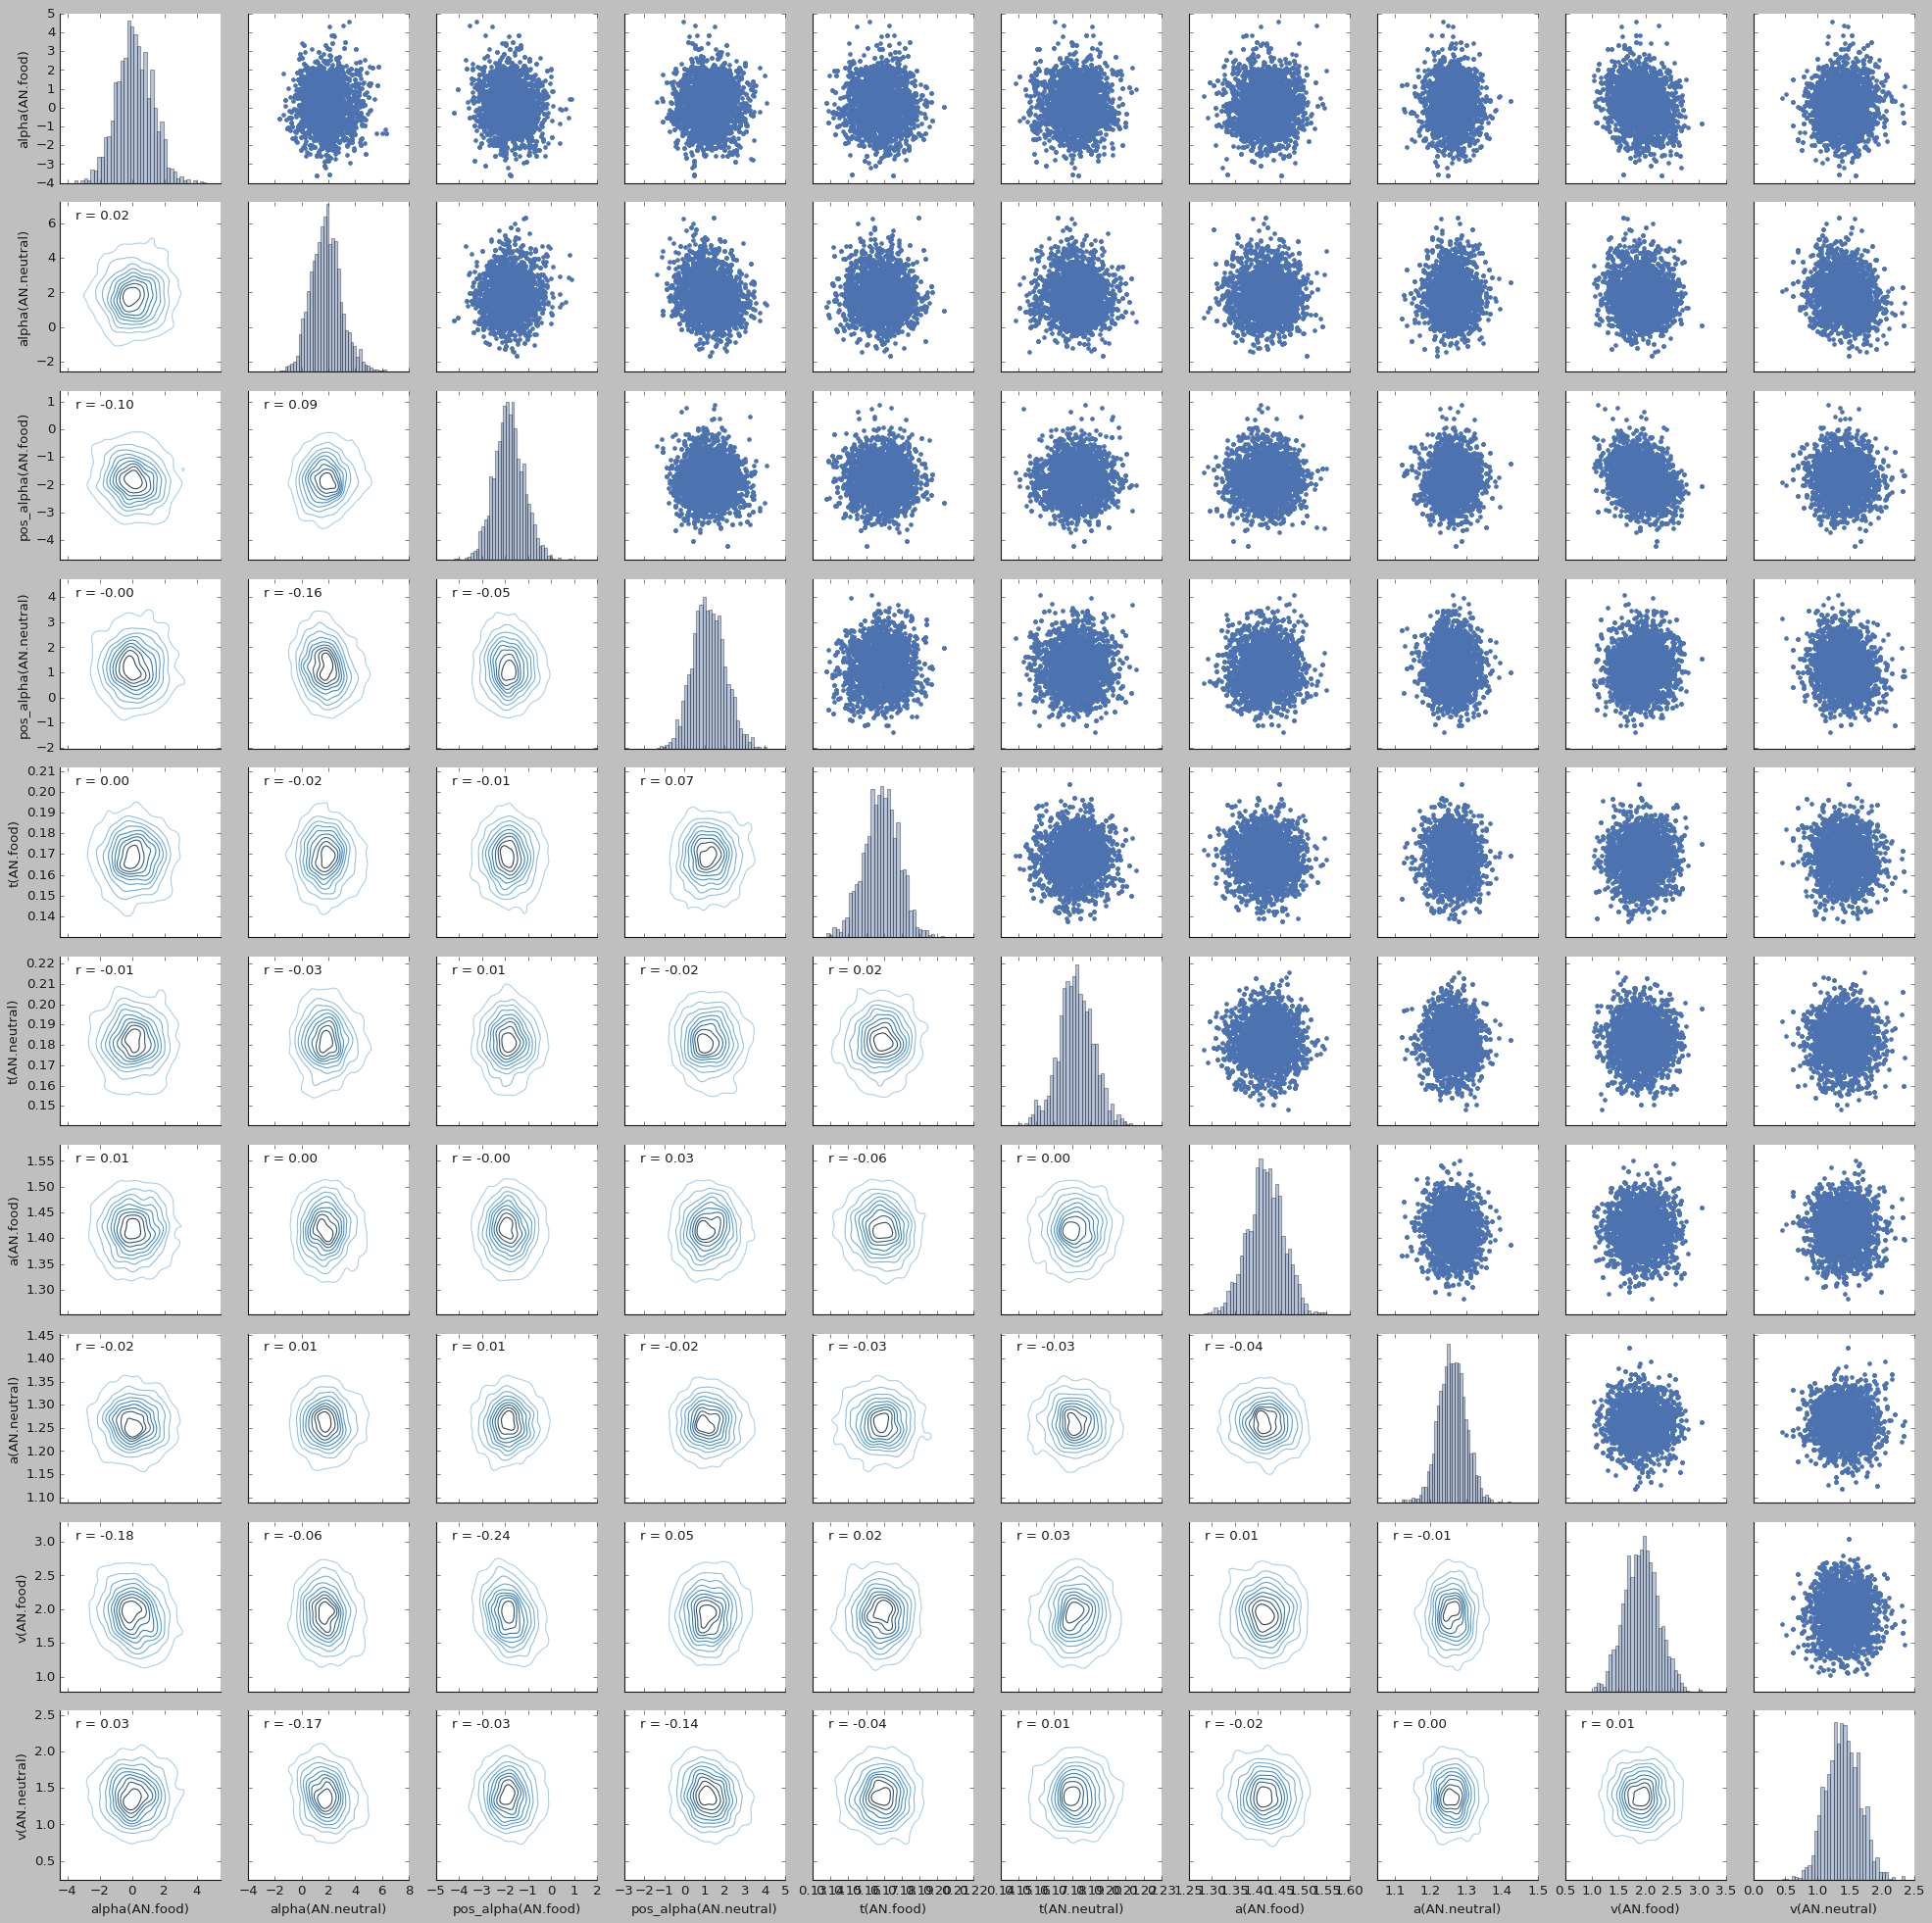

In [29]:
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')


## Posterior predictive checks


An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).


#### AN food


In [219]:
data = data[
    (data.subj_code == "am_gu_1999_02_11_937_f") |  # AN
    (data.subj_code == "an_de_1998_11_10_289_f") |  # AN
    (data.subj_code == "gi_lo_2001_06_20_106_f") |  # HC
    (data.subj_code == "bi_ra_2000_09_28_341_f")   # HC
]

d = data[(data.diag_cat == "AN")]
d.shape


(640, 10)

In [234]:
d = data

In [220]:
# Change subj_idx
d.loc[d.subj_code == "am_gu_1999_02_11_937_f", "subj_idx"] = 0
d.loc[d.subj_code == "an_de_1998_11_10_289_f", "subj_idx"] = 1

d.tail()


,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
11195,1,1,neutral,0.527,158,1,1,AN,an_de_1998_11_10_289_f,0.5
11196,1,0,food,0.488,159,0,0,AN,an_de_1998_11_10_289_f,0.5
11197,1,1,neutral,0.323,159,1,1,AN,an_de_1998_11_10_289_f,0.5
11198,1,1,food,0.499,160,0,1,AN,an_de_1998_11_10_289_f,0.5
11199,1,1,neutral,0.402,160,1,1,AN,an_de_1998_11_10_289_f,0.5


In [236]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        d,
        # bias=True,
        p_outlier=0.05
    )
    m.sample(600, burn=100, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 727.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 766.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 780.3 sec

In [52]:
# Combine the models
# m = kabuki.utils.concat_models(models)
traces = m.get_traces()
traces.head()


,a(AN.food),a(AN.neutral),a(AN_R.food),a(AN_R.neutral),a(BN.food),a(BN.neutral),a(BN_R.food),a(BN_R.neutral),a(HC.food),a(HC.neutral),...,pos_alpha_subj(RI.neutral).175,pos_alpha_subj(RI.neutral).178,pos_alpha_subj(RI.neutral).192,pos_alpha_subj(RI.neutral).208,pos_alpha_subj(RI.neutral).210,pos_alpha_subj(RI.neutral).223,pos_alpha_subj(RI.neutral).228,pos_alpha_subj(RI.neutral).244,pos_alpha_subj(RI.neutral).279,pos_alpha_subj(RI.neutral).286
0,1.419147,1.302546,1.175882,1.363120,1.384228,1.084609,1.323063,1.427180,1.344488,1.280353,...,0.295609,0.139912,0.108769,0.104712,0.084675,0.129573,0.176320,0.245254,0.161436,0.178513
1,1.345688,1.211257,1.267658,1.351603,1.432092,1.083462,1.346401,1.444872,1.315966,1.268457,...,0.155061,0.134077,0.074951,0.307244,0.070489,0.153472,0.206688,0.154490,0.306958,0.224305
2,1.427129,1.322904,1.407411,1.408192,1.523244,1.243772,1.409840,1.140137,1.350847,1.252018,...,0.338768,0.265431,0.093580,0.066371,0.106976,0.295046,0.208696,0.124594,0.095323,0.224523
3,1.356022,1.350327,1.267006,1.231057,1.391070,1.215077,1.318142,1.422669,1.340157,1.244962,...,0.035280,0.181331,0.102702,0.304889,0.108507,0.216067,0.265623,0.218978,0.103937,0.078373
4,1.338982,1.316591,1.435211,1.250458,1.326826,1.243233,1.391460,1.181983,1.331754,1.260010,...,0.263810,0.173877,0.242322,0.299826,0.137289,0.217771,0.126325,0.057155,0.128853,0.109847


Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate pos*alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate* for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.


In [238]:
df = hddm.generate.gen_rand_rlddm_data(
    a=1.4,
    t=0.3,
    alpha=0.5,
    scaler=2,
    p_upper=0.7,
    p_lower=0.3,
    subjs=2,
    split_by=0,
    size=10
)


In [239]:
print(df)


       q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       0.0  0.942301       0.0         0   
1  0.500000  0.253681   0.385249       1.0  0.482301       1.0         0   
2  0.746319  0.253681   0.770498       1.0  0.715301       1.0         0   
3  0.871292  0.253681   0.965959       1.0  0.421301       1.0         0   
4  0.934698  0.253681   1.065128       1.0  1.078301       1.0         0   
5  0.966868  0.253681   1.115443       1.0  0.441301       0.0         0   
6  0.490552  0.253681   0.370473       1.0  0.509301       1.0         0   
7  0.741526  0.253681   0.763001       1.0  1.793301       0.0         0   
8  0.376222  0.253681   0.191657       1.0  0.497301       1.0         0   
9  0.683519  0.253681   0.672277       0.0  0.796301       0.0         0   
0  0.500000  0.500000   0.000000       1.0  0.538185       1.0         1   
1  0.709846  0.500000   0.318455       0.0  0.884185       0.0         1   
2  0.709846 

In [240]:
from tqdm import tqdm  # progress tracker
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
d['samp'] = 0
# load traces
traces = m.get_traces()


In [242]:
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 10)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0]-1)
    # loop through all subjects in observed data
    for s in d.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 0)].trial.unique())
        size1 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 1)].trial.unique())
        # size2 = len(d[(d['subj_idx']==s) & (d['split_by']==2)].trial.unique())
        # set parameter values for simulation
        a = traces.loc[sample, 'a_subj.'+str(s)]
        t = traces.loc[sample, 't_subj.'+str(s)]
        scaler = traces.loc[sample, 'v_subj.'+str(s)]
        alphaInv = traces.loc[sample, 'alpha_subj.'+str(s)]
        # #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        # #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size0, p_upper=0.7, p_lower=0.3, split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size1, p_upper=0.7, p_lower=0.3, split_by=1)
        # #sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        # #append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # #assign subj_idx
        sim_data0['subj_idx'] = s
        # #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        # #identify the simulated data
        sim_data0['samp'] = i
        # #append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)


  0%|          | 0/9 [00:21<?, ?it/s]


KeyError: 0

In [227]:
# combine observed and simulated data
ppc_data = d[['subj_idx', 'response', 'split_by',
              'rt', 'trial', 'feedback', 'samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx', 'response', 'split_by',
                      'rt', 'trial', 'feedback', 'type', 'samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')


In [228]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

In [229]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)).astype('int64')
# calculate means for each sample
sums = plot_ppc_data.groupby(
    ['bin_trial', 'split_by', 'samp', 'type']).mean().reset_index()
# calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial', 'split_by', 'type']).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial'] == ppc_sim.bin_trial[i]) & (
        sums['split_by'] == ppc_sim.split_by[i]) & (sums['type'] == ppc_sim.type[i])], alpha=0.1)
    ppc_sim.loc[i, 'upper_hpd'] = hdi[1]
    ppc_sim.loc[i, 'lower_hpd'] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')


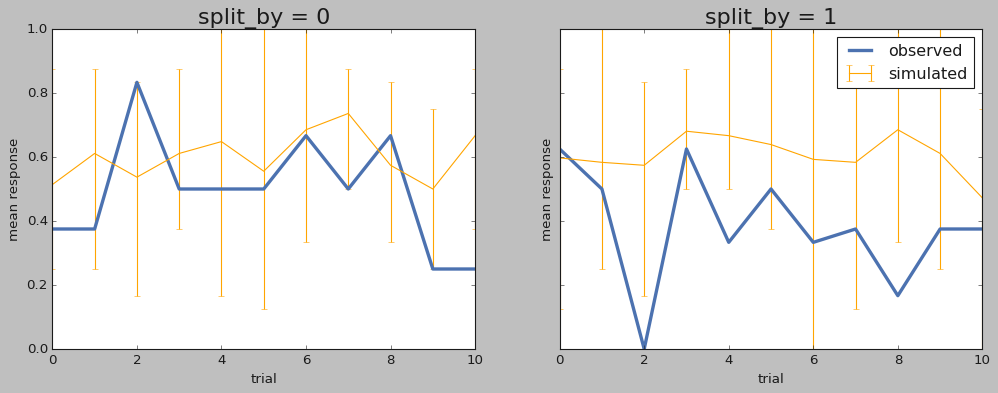

In [230]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1,
                        ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[
                d.low_err, d.up_err], label='simulated', color='orange')
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'observed')]
    ax.plot(d.bin_trial, d.response, linewidth=3, label='observed')
    ax.set_title('split_by = %i' % i, fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')


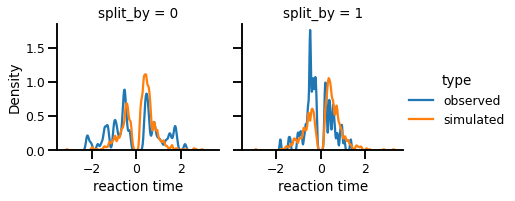

In [208]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(
    plot_ppc_data['response'] == 1, plot_ppc_data.rt, 0-plot_ppc_data.rt)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col='split_by', hue='type')
g.map(sns.kdeplot, 'reaction time', bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')


## Parameter recovery


In [21]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'recovery_sim_est_rlddm.csv'